# Interval MPC
First version of new scheduling method

In [29]:
import pyomo.environ as pyo
import pandas as pd
from math import pi
import matplotlib.pyplot as plt
import numpy as np


import os
import sys


print("Working directory:", os.getcwd())


Working directory: c:\Users\fh6281\PycharmProjects\GermanBuildingDate\03_optimization\playground


In [2]:
t_inc = 15 / 60  # 15 minutes in hours
eta_ch = 0.95  # Charging efficiency
eta_dis = 0.95  # Discharging efficiency
capacity_min = 0.0  # Minimum capacity of the battery in kWh
capacity_max = 13.5  # Maximum capacity of the battery in kWh
power_min = -3.0  # Minimum power of the battery in kW
power_max = 3.0  # Maximum power of the battery in kW

## Utility Functions
Copy Pasta

In [3]:
def simpsons_rule(lb, ub, n, pdf, weights, offset=0):
    ''' Numerical integration of the pdf using Simpson's rule.

    If a better approximation of the integrals is necessary, a different approximation rule could be implemented. 
    See e.g. Gaussian quadrature that allows a variable step-length. 
    
    Args:
    lb (float): lower bound of the integration
    ub (float): upper bound of the integration
    n (int): number of breakpoints between lb and ub
    pdf (function): generic pdf formula
    weights (list): weights for the pdf formula
    offset (float): offset to represent a shifted pdf    
    '''
    h = (ub - lb) / n  # step size
    x = [lb + i * h for i in range(n+1)]
    integrand = lambda x, w: x * pdf((x + offset), *w)
    y = [integrand(xi, weights) for xi in x]

    approximated_integral = h / 3 * (y[0] + y[-1] + 4 * sum(y[1:-1:2]) + 2 * sum(y[2:-1:2]))
    return approximated_integral


In [4]:
def cdf_formula(name):
    ''' Returns the CDF formula for the specified distribution. Currently, the following distributions are supported:
    - normal: normal distribution
    - gmm2: sum of two gaussian distributions '''

    def cdf_normal(x, mu, sig):
        ''' Gaussian CDF computation via Abramowitz-Stegun approximation without if-statements (Pyomo cannot use If-Statements). '''

        z = (x - mu) / sig  # standardize the normal distribution

        epsilon = 1e-6  # to avoid division by zero => Needed for sign function approximation
        sign_z = z / (pyo.sqrt(z**2 + epsilon))  # sign function approximation

        z_abs = z * sign_z  # absolute value of z

        d1 = 0.0498673470  # Coefficients for the Abramowitz-Stegun approximation
        d2 = 0.0211410061
        d3 = 0.0032776263
        d4 = 0.0000380036
        d5 = 0.0000488906
        d6 = 0.0000053830 

        t = 1 + d1 * z_abs + d2 * z_abs**2 + d3 * z_abs**3 + d4 * z_abs**4 + d5 * z_abs**5 + d6 * z_abs**6 

        return 0.5 + 0.5 * sign_z * (1 - t**(-16))

    def cdf_normal_wrong(x, mu, sig):
        ''' A try of a CDF approximation via Double Factorial (!!) => Seems to be wrong (For formula see https://en.wikipedia.org/wiki/Normal_distribution) (error function cannot be used in Pyomo) '''
        return 0.5 + 1/(2*pi)**0.5 * pyo.exp(-0.5 * ((x-mu)/sig)**2) * sum([((x-mu)/sig)**(i) / (pyo.prod(range(1, i+1, 2))) for i in range(1, int(2*40), 2)])
     
    
    if name == 'normal':
        return cdf_normal

    elif name == 'normal_wrong_way': 
        return cdf_normal_wrong      

    elif name == 'sum-2-logistic-distributions':
        return lambda x, w1, w2, w3, w4, w5, w6: w1 / (1 + pyo.exp(-w2 *(x - w3))) + w4 / (1 + pyo.exp(-w5 *(x - w6)))

    elif name == 'gmm2':
        return lambda x, w1, mu1, sig1, w2, mu2, sig2: w1 * cdf_normal(x, mu1, sig1) + w2 * cdf_normal(x, mu2, sig2)
    
    else:
        raise ValueError(f'CDF formula {name} not recognized')

In [5]:
def pdf_formula(name):
    ''' Returns the PDF formula for the specified distribution. '''
    if name == 'normal' or name == 'normal_wrong_way':
        return lambda x, mu, sig: 1 / (sig * pyo.sqrt(2 * pi)) * pyo.exp(-0.5 * ((x - mu) / sig)**2)
    
    elif name == 'sum-2-logistic-distributions':
        return lambda x, w1, w2, w3, w4, w5, w6: w1 * w2 * pyo.exp(-w2 * (x - w3)) / (1 + pyo.exp(-w2 * (x - w3)))**2 + w4 * w5 * pyo.exp(-w5 * (x - w6)) / (1 + pyo.exp(-w5 * (x - w6)))**2
    
    elif name == 'gmm2':
        return lambda x, w1, mu1, sig1, w2, mu2, sig2: w1 / (sig1 * pyo.sqrt(2 * pi)) * pyo.exp(-0.5 * ((x - mu1) / sig1)**2) + w2 / (sig2 * pyo.sqrt(2 * pi)) * pyo.exp(-0.5 * ((x - mu2) / sig2)**2) 

    else:
        raise ValueError(f'PDF formula {name} not recognized')

## Scheduler

<Axes: xlabel='timestamp'>

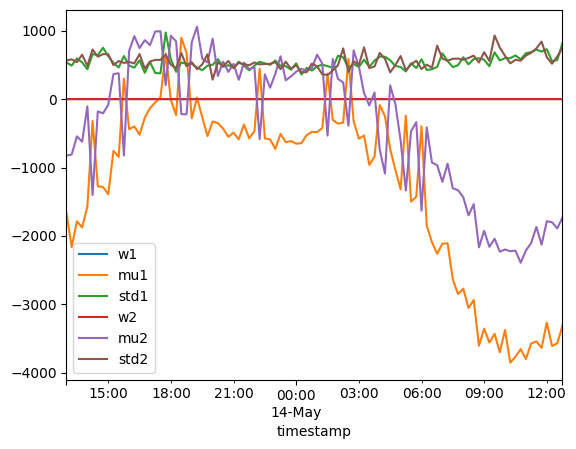

In [6]:
df_fc = pd.read_csv("..\\..\\02_forecast\\storage_param_fc\\file_fc_parametric_PatchTST_SFH3_2025-07-16_13-47-24_freq15_CreationTime2025-07-18_10-26.csv", index_col=[0,1], parse_dates=True)

# Here we should onlyload a single forecast with 24 * 4 entries. Later on the simulationengine will prepare the forecasts for the simulation.
# Only take the first time_fc_created entry
df_fc_single = df_fc.loc[df_fc.index.get_level_values('time_fc_created') == df_fc.index.get_level_values('time_fc_created')[-1]]

# Drop the time_fc_created index level
df_fc_single = df_fc_single.reset_index(level='time_fc_created', drop=True)
df_fc_single.index = pd.DatetimeIndex(df_fc_single.index.get_level_values('timestamp'), freq='15min')
time_index = df_fc_single.index


df_fc_single.plot()

In [7]:
df_fc_single

,w1,mu1,std1,w2,mu2,std2
timestamp,,,,,,
2020-05-13 13:00:00+00:00,0.645019,-1666.174518,536.043124,0.354981,-825.474271,566.801718
2020-05-13 13:15:00+00:00,0.563313,-2164.670959,490.819937,0.436687,-809.836667,581.493594
2020-05-13 13:30:00+00:00,0.566140,-1785.792848,595.872138,0.433860,-543.879777,540.878909
2020-05-13 13:45:00+00:00,0.458277,-1875.751901,537.529877,0.541723,-622.046052,649.907916
2020-05-13 14:00:00+00:00,0.549916,-1570.225973,437.478448,0.450084,-106.123341,487.158217
...,...,...,...,...,...,...
2020-05-14 11:45:00+00:00,0.571996,-3637.942534,695.109115,0.428004,-2127.621850,841.209172
2020-05-14 12:00:00+00:00,0.646042,-3267.602669,730.492654,0.353958,-1785.029301,612.627637
2020-05-14 12:15:00+00:00,0.598217,-3609.971139,554.597265,0.401783,-1800.198071,517.903415


In [8]:
# drop the fc_creaation time from the index
pdf_weights = df_fc_single.copy()

# Convert the DataFrame into a Series of lists containing the weights
pdf_weights = pdf_weights.apply(lambda row: row.tolist(), axis=1)
pdf_weights

timestamp
2020-05-13 13:00:00+00:00    [0.6450191603636053, -1666.1745176250065, 536....
2020-05-13 13:15:00+00:00    [0.5633132606283638, -2164.670958600172, 490.8...
2020-05-13 13:30:00+00:00    [0.566140019011564, -1785.7928482336345, 595.8...
2020-05-13 13:45:00+00:00    [0.4582774184934075, -1875.751901356277, 537.5...
2020-05-13 14:00:00+00:00    [0.5499164166892553, -1570.2259733568155, 437....
                                                   ...                        
2020-05-14 11:45:00+00:00    [0.5719956559627961, -3637.942533794622, 695.1...
2020-05-14 12:00:00+00:00    [0.6460417831432087, -3267.602669165808, 730.4...
2020-05-14 12:15:00+00:00    [0.598216775914974, -3609.971138676653, 554.59...
2020-05-14 12:30:00+00:00    [0.4269389815179089, -3570.6648404601533, 572....
2020-05-14 12:45:00+00:00    [0.5199910680211586, -3314.282140238337, 818.7...
Freq: 15min, Length: 96, dtype: object

In [9]:
model = pyo.ConcreteModel()


# Sets
model.time = pyo.Set(initialize=time_index)
model.time_e = pyo.Set(initialize=time_index.append(pd.Index([time_index[-1] + time_index.freq])))
model.time_e0 = pyo.Set(initialize=time_index.to_list()[:1])


# Parameters
model.e0 = pyo.Param(model.time_e0, initialize=2.5)
model.pdf_weights = pyo.Param(model.time, initialize=pdf_weights, domain=pyo.Any) 
# TODO: Add dynamic bounds of PDFs


# Decision Variables
# Battery Power
model.pb_exp = pyo.Var(model.time, domain=pyo.Reals)
model.y_low = pyo.Var(model.time, domain=pyo.Reals)
model.y_high = pyo.Var(model.time, domain=pyo.Reals)

# Battery Energy
model.e_exp = pyo.Var(model.time_e, domain=pyo.Reals)
model.e_min = pyo.Var(model.time_e, domain=pyo.Reals)
model.e_max = pyo.Var(model.time_e, domain=pyo.Reals)

# Complementary variables
model.y_low_ch = pyo.Var(model.time, domain=pyo.NonPositiveReals)
model.y_low_dis = pyo.Var(model.time, domain=pyo.NonNegativeReals)
model.y_high_ch = pyo.Var(model.time, domain=pyo.NonPositiveReals)
model.y_high_dis = pyo.Var(model.time, domain=pyo.NonNegativeReals)
model.pb_exp_ch = pyo.Var(model.time, domain=pyo.NonPositiveReals)
model.pb_exp_dis = pyo.Var(model.time, domain=pyo.NonNegativeReals)

# Probabilities of being out of bounds [y_low, y_high]
model.prob_low = pyo.Var(model.time, domain=pyo.NonNegativeReals, bounds=(0, 1))
model.prob_high = pyo.Var(model.time, domain=pyo.NonNegativeReals, bounds=(0, 1))

# Expected grid power
model.pg_exp_buy = pyo.Var(model.time, domain=pyo.NonNegativeReals)
model.pg_exp_sell = pyo.Var(model.time, domain=pyo.NonPositiveReals)

In [10]:
# Some More Params


cdf = cdf_formula('gmm2')  # TODO: Rename gmm2 to sum2gaussian
pdf = pdf_formula('gmm2')  # TODO: Rename gmm2 to sum2gaussian
#simpsons_rule = lambda x1, x2, x3: 1  # TODO: Code real Simpson's rule for numerical integration

In [11]:
# Constraints

# Battery Evolution
def constr_e_min(model, t):
    ''' e_min[t] = e_min[t-1] - y_high_ch[t-1] * dt * eta_ch - y_high_dis[t-1] * dt / eta_dis '''
    if t == model.time_e.first():
        return model.e_min[t] == model.e0[t]
    else:
        t_prev = model.time_e.prev(t)
        return model.e_min[t] == model.e_min[t_prev] - model.y_high_ch[t_prev] * t_inc * eta_ch - model.y_high_dis[t_prev] * t_inc / eta_dis
model.constr_e_min = pyo.Constraint(model.time_e, rule=constr_e_min)


def constr_e_max(model, t):
    ''' e_max[t] = e_max[t-1] - y_low_ch[t-1] * dt * eta_ch - y_low_dis[t-1] * dt / eta_dis '''
    if t == model.time_e.first():
        return model.e_max[t] == model.e0[t]
    else:
        t_prev = model.time_e.prev(t)
        return model.e_max[t] == model.e_max[t_prev] - model.y_low_ch[t_prev] * t_inc * eta_ch - model.y_low_dis[t_prev] * t_inc / eta_dis
model.constr_e_max = pyo.Constraint(model.time_e, rule=constr_e_max)



def constr_e_exp(model, t):
    ''' e_exp[t] = e_exp[t-1] - pb_exp_ch[t-1] * dt * eta_ch - pb_exp_dis[t-1] * dt / eta_dis '''
    if t == model.time_e.first():
        return model.e_exp[t] == model.e0[t]
    else:
        t_prev = model.time_e.prev(t)
        return model.e_exp[t] == model.e_exp[t_prev] - model.pb_exp_ch[t_prev] * t_inc * eta_ch - model.pb_exp_dis[t_prev] * t_inc / eta_dis
model.constr_e_exp = pyo.Constraint(model.time_e, rule=constr_e_exp)




# Battery Limits
def constr_e_min_limit(model, t):
    ''' e_min[t] >= capacity_min '''
    return model.e_min[t] >= capacity_min
model.constr_e_min_limit = pyo.Constraint(model.time_e, rule=constr_e_min_limit)

def constr_e_max_limit(model, t):
    ''' e_max[t] <= capacity_max '''
    return model.e_max[t] <= capacity_max
model.constr_e_max_limit = pyo.Constraint(model.time_e, rule=constr_e_max_limit)

def constr_y_low_limit(model, t):
    ''' y_low[t] >= power_min'''
    return model.y_low[t] >= power_min
model.constr_y_low_limit = pyo.Constraint(model.time, rule=constr_y_low_limit)

def constr_y_high_limit(model, t):
    ''' y_high[t] <= power_max'''
    return model.y_high[t] <= power_max
model.constr_y_high_limit = pyo.Constraint(model.time, rule=constr_y_high_limit)




# Complementary Constraints
def constr_y_low_split(model, t):
    ''' y_low[t] = y_low_ch[t] + y_low_dis[t] '''
    return model.y_low[t] == model.y_low_ch[t] + model.y_low_dis[t]
model.constr_y_low_split = pyo.Constraint(model.time, rule=constr_y_low_split)

def constr_y_low_relaxation(model, t):
    ''' -1e-8 <= y_low_ch[t] * y_low_dis[t] <= 0 '''
    return pyo.inequality(-1e-8, model.y_low_ch[t] * model.y_low_dis[t], 0)  
model.constr_y_low_relaxation = pyo.Constraint(model.time, rule=constr_y_low_relaxation)

def constr_y_high_split(model, t):
    ''' y_high[t] = y_high_ch[t] + y_high_dis[t] '''
    return model.y_high[t] == model.y_high_ch[t] + model.y_high_dis[t]
model.constr_y_high_split = pyo.Constraint(model.time, rule=constr_y_high_split)

def constr_y_high_relaxation(model, t):
    ''' -1e-8 <= y_high_ch[t] * y_high_dis[t] <= 0 '''
    return pyo.inequality(-1e-8, model.y_high_ch[t] * model.y_high_dis[t], 0)
model.constr_y_high_relaxation = pyo.Constraint(model.time, rule=constr_y_high_relaxation)

def constr_pb_exp_split(model, t):
    ''' pb_exp[t] = pb_exp_ch[t] + pb_exp_dis[t] '''
    return model.pb_exp[t] == model.pb_exp_ch[t] + model.pb_exp_dis[t]
model.constr_pb_exp_split = pyo.Constraint(model.time, rule=constr_pb_exp_split)

def constr_pb_exp_relaxation(model, t):
    ''' -1e-8 <= pb_exp_ch[t] * pb_exp_dis[t] <= 0 '''
    return pyo.inequality(-1e-8, model.pb_exp_ch[t] * model.pb_exp_dis[t], 0)
model.constr_pb_exp_relaxation = pyo.Constraint(model.time, rule=constr_pb_exp_relaxation)





# Charging / Discharging Constraints
def constr_y_low_ch(model, t):
    ''' y_low_ch[t] <= 0 '''
    return model.y_low_ch[t] <= 0
model.constr_y_low_ch = pyo.Constraint(model.time, rule=constr_y_low_ch)

def constr_y_low_dis(model, t):
    ''' y_low_dis[t] >= 0 '''
    return model.y_low_dis[t] >= 0
model.constr_y_low_dis = pyo.Constraint(model.time, rule=constr_y_low_dis)

def constr_y_high_ch(model, t):
    ''' y_high_ch[t] <= 0 '''
    return model.y_high_ch[t] <= 0
model.constr_y_high_ch = pyo.Constraint(model.time, rule=constr_y_high_ch)

def constr_y_high_dis(model, t):
    ''' y_high_dis[t] >= 0 '''
    return model.y_high_dis[t] >= 0
model.constr_y_high_dis = pyo.Constraint(model.time, rule=constr_y_high_dis)

def constr_pb_exp_ch(model, t):
    ''' pb_exp_ch[t] <= 0 '''
    return model.pb_exp_ch[t] <= 0
model.constr_pb_exp_ch = pyo.Constraint(model.time, rule=constr_pb_exp_ch)

def constr_pb_exp_dis(model, t):
    ''' pb_exp_dis[t] >= 0 '''
    return model.pb_exp_dis[t] >= 0
model.constr_pb_exp_dis = pyo.Constraint(model.time, rule=constr_pb_exp_dis)




# Order of y_low and y_high
def constr_y_order(model, t):
    ''' y_low[t] <= y_high[t] '''
    return model.y_low[t] <= model.y_high[t]
model.constr_y_order = pyo.Constraint(model.time, rule=constr_y_order)




# Probabilities of not being fully covered by the battery
def constr_prob_low(model, t):
    ''' prob_low[t] = CDF[t](y_low[t]) '''
    return model.prob_low[t] == cdf(model.y_low[t], *model.pdf_weights[t])
model.constr_prob_low = pyo.Constraint(model.time, rule=constr_prob_low)

def constr_prob_high(model, t):
    ''' prob_high[t] = 1 - CDF[t](y_high[t]) '''
    return model.prob_high[t] == 1 - cdf(model.y_high[t], *model.pdf_weights[t])
model.constr_prob_high = pyo.Constraint(model.time, rule=constr_prob_high)




# Expected Battery Power
def constr_pb_exp(model, t):
    ''' pb_exp[t] = prob_low[t] * y_low[t] + prob_high[t] * y_high[t] + INTEGRAL[z*pdf(weights[t], z)] bounds=[y_low[t], y_high[t]] '''
    return model.pb_exp[t] == model.prob_low[t] * model.y_low[t] + model.prob_high[t] * model.y_high[t] + simpsons_rule(model.y_low[t], model.y_high[t], n=200, pdf=pdf, weights=model.pdf_weights[t], offset=0) # TODO: Adjust parameters
model.constr_pb_exp = pyo.Constraint(model.time, rule=constr_pb_exp)


def constr_pg_exp_sell(model, t):
    ''' pg_exp_sell[t] = INTEGRAL[z*pdf(weights[t], z+y_low[t])] bounds=[-inf, 0]'''  # TODO: Maybe use historical minimum as integration bound? Does that cause issues since the pdf tails might be too long?
    return model.pg_exp_sell[t] == simpsons_rule(-15.0, 0, n=200, pdf=pdf, weights=model.pdf_weights[t], offset=model.y_low[t])  # TODO: Code dynamic bounds
model.constr_pg_exp_sell = pyo.Constraint(model.time, rule=constr_pg_exp_sell)

def constr_pg_exp_buy(model, t):
    ''' pg_exp_buy[t] = INTEGRAL[z*pdf(weights[t], z+y_high[t])] bounds=[0, inf]'''  # TODO: Maybe use historical maximum as integration bound? Does that cause issues since the pdf tails might be too long?
    return model.pg_exp_buy[t] == simpsons_rule(0, 15.0, n=200, pdf=pdf, weights=model.pdf_weights[t], offset=model.y_high[t])  # TODO: Code dynamic bounds
model.constr_pg_exp_buy = pyo.Constraint(model.time, rule=constr_pg_exp_buy)


In [12]:
# create a pandas series element with time_index as index and constant values
c_sell_fake = pd.Series(0.5, index=time_index, name='c_sell')
c_buy_fake = pd.Series(1.0, index=time_index, name='c_buy')
c_soe_end = 1.0
c_sell_fake

timestamp
2020-05-13 13:00:00+00:00    0.5
2020-05-13 13:15:00+00:00    0.5
2020-05-13 13:30:00+00:00    0.5
2020-05-13 13:45:00+00:00    0.5
2020-05-13 14:00:00+00:00    0.5
                            ... 
2020-05-14 11:45:00+00:00    0.5
2020-05-14 12:00:00+00:00    0.5
2020-05-14 12:15:00+00:00    0.5
2020-05-14 12:30:00+00:00    0.5
2020-05-14 12:45:00+00:00    0.5
Freq: 15min, Name: c_sell, Length: 96, dtype: float64

In [13]:
# Objective Function
def objective(model):
    '''' Minimize the expected costs associated with the grid exchange. To discourage a total discharge
        of the battery, we reward the expected battery energy at the end of the horizon. '''
    sum_costs = sum(
        c_sell_fake[t] * model.pg_exp_sell[t]
        + c_buy_fake[t] * model.pg_exp_buy[t]
        for t in model.time
    ) 
    #+ c_soe_end * model.e_exp[model.time_e.last()]

    return sum_costs
model.objective = pyo.Objective(rule=objective, sense=pyo.minimize)


In [14]:
# Solver
def solve(model):
    solver = pyo.SolverFactory('ipopt')
    #solver.options['mu_strategy'] = 1       
    #solver.options['tol'] = 1e-8            
    #solver.options['acceptable_tol'] = 1e-8 
    #solver.options['max_step'] = 1e-1 
    solver.options['max_iter'] = 5000
    result = solver.solve(model, tee=True)
    return result

In [15]:
x = solve(model)

Ipopt 3.11.1: max_iter=5000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     3267
Number of nonzeros in inequality constraint Jacobian.:     1730
Number of nonzeros in Lagrangian Hessian.............:      768

Total number of variables............................:     1539
                     variables with only lower bounds:      384
                variables with lower and upper bou

## Evaluation

In [16]:
e_min = model.e_min.get_values()
e_max = model.e_max.get_values()

<Axes: title={'center': 'Min/Max Battery Energy'}, xlabel='Time', ylabel='kWh'>

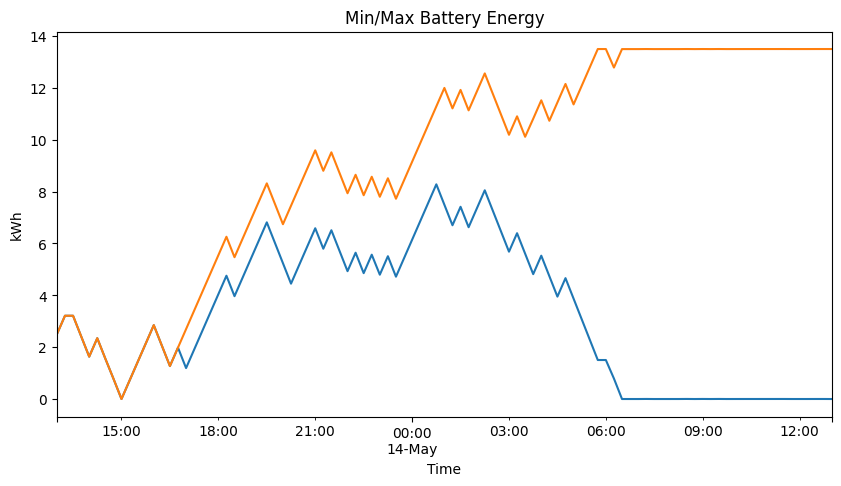

In [17]:
e_min = pd.Series(e_min, index=model.time_e, name='e_min')
e_max = pd.Series(e_max, index=model.time_e, name='e_max')
e_min.plot(title='Minimum Battery Energy', ylabel='kWh', xlabel='Time', figsize=(10, 5))
e_max.plot(title='Min/Max Battery Energy', ylabel='kWh', xlabel='Time', figsize=(10, 5))

In [18]:
model.pg_exp_buy.display()
model.pg_exp_sell.display()

pg_exp_buy : Size=96, Index=time
    Key                       : Lower : Value                  : Upper : Fixed : Stale : Domain
    2020-05-13 13:00:00+00:00 :     0 :   0.009973196425755275 :  None : False : False : NonNegativeReals
    2020-05-13 13:15:00+00:00 :     0 :   0.012478341334737134 :  None : False : False : NonNegativeReals
    2020-05-13 13:30:00+00:00 :     0 :    0.02163763046361687 :  None : False : False : NonNegativeReals
    2020-05-13 13:45:00+00:00 :     0 :   0.023288918267756958 :  None : False : False : NonNegativeReals
    2020-05-13 14:00:00+00:00 :     0 :   0.040446292666103244 :  None : False : False : NonNegativeReals
    2020-05-13 14:15:00+00:00 :     0 :   0.037515469893798566 :  None : False : False : NonNegativeReals
    2020-05-13 14:30:00+00:00 :     0 :   0.038378595684540065 :  None : False : False : NonNegativeReals
    2020-05-13 14:45:00+00:00 :     0 :   0.045821456529566505 :  None : False : False : NonNegativeReals
    2020-05-13 15:00:00

<Axes: title={'center': 'Battery Power'}, xlabel='Time', ylabel='kW'>

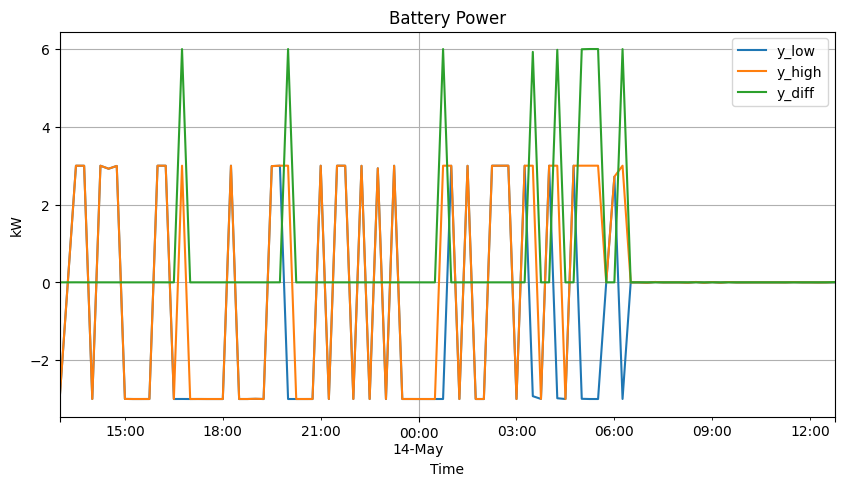

In [40]:
df = pd.DataFrame({
    'y_low': [pyo.value(model.y_low[t]) for t in model.time],
    'y_high': [pyo.value(model.y_high[t]) for t in model.time],
    'y_diff': [pyo.value(model.y_high[t]) - pyo.value(model.y_low[t]) for t in model.time],
}, index=list(model.time))
df.plot(grid=True, title='Battery Power', ylabel='kW', xlabel='Time', figsize=(10, 5))

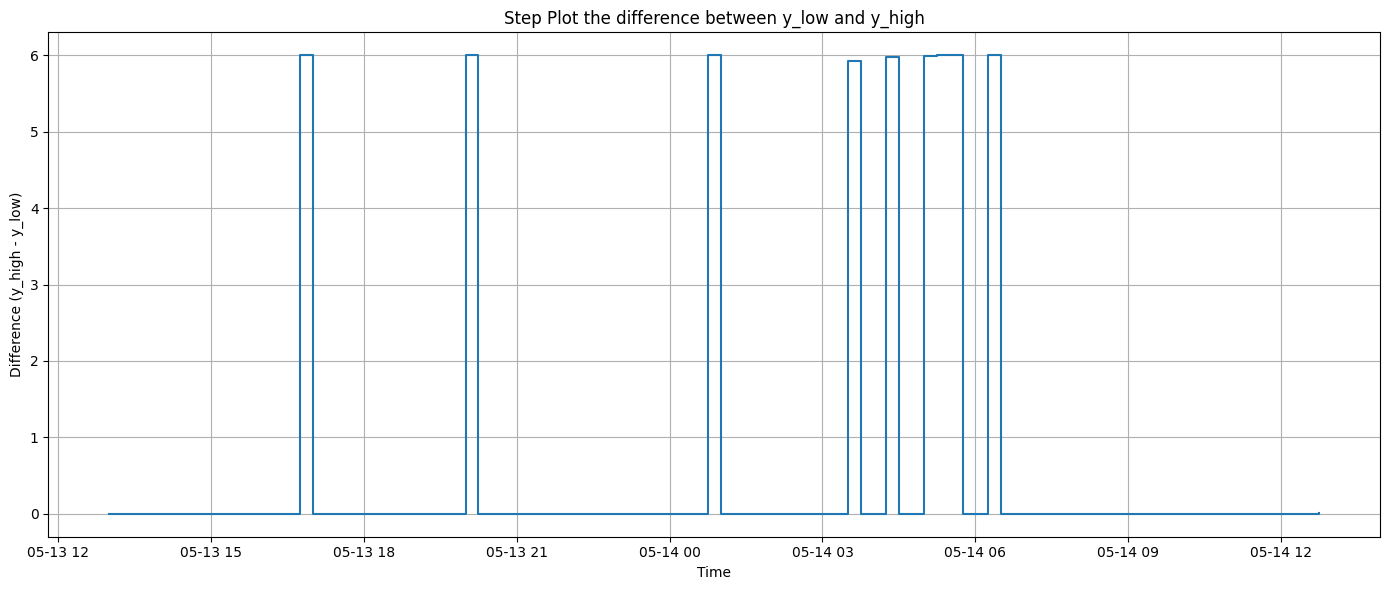

In [42]:
plt.figure(figsize=(14, 6))
plt.step(df.index, df['y_diff'], where='post')
#plt.step(df.index, df['y_high'], '--', where='post', color='orange')
plt.title("Step Plot the difference between y_low and y_high")
plt.xlabel("Time")
plt.ylabel("Difference (y_high - y_low)")
plt.grid(True)
plt.tight_layout()
#plt.legend(['y_low', 'y_high'])
plt.show()

In [44]:
pb_low = [pyo.value(model.y_low[t]) for t in model.time]
pb_low

[-2.9984193231170484,
 -0.0011897554507541317,
 2.9983568471634117,
 2.997827148794097,
 -2.9992074577779912,
 2.998508941388176,
 2.921510802750373,
 2.993805986327628,
 -2.9975800923518356,
 -2.9998839119355165,
 -2.9998271509611047,
 -2.9993663526167955,
 2.9987881773960647,
 2.998650830321327,
 -2.9997921404941157,
 -2.99881920814159,
 -2.999848900292985,
 -2.9992970855430316,
 -2.9998919503461403,
 -2.9998950475599897,
 -2.999895410653291,
 2.9989916254151336,
 -2.9998921011243644,
 -2.999763221065535,
 -2.9945117055845083,
 -2.9998546728608892,
 2.9888555928310656,
 2.9986806171183806,
 -2.9997384840972905,
 -2.9998152650611845,
 -2.999806807917661,
 -2.9994984819106767,
 2.9989044144348247,
 -2.999482193104321,
 2.998963007245737,
 2.998770059926867,
 -2.9985726425211383,
 2.99660380399336,
 -2.999778438380393,
 2.931854475011045,
 -2.999529773772307,
 2.9981368963596196,
 -2.9994502964531367,
 -2.999402100029805,
 -2.999847606990463,
 -2.9999303370453547,
 -2.9998930036369233,
